## IFT6135 Assignment2, Programming part

#### Qestion 1(C): CNN batch normalization

Names: Xiao Fan (20086722) ,  Zhibin Lu (20091078)

In [15]:
import time
import numpy as np
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms

import matplotlib.pyplot as plt


In [16]:
mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transforms, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=mnist_transforms, download=True)
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=2)

print('mnist_train:',len(mnist_train))
print('mnist_test:',len(mnist_test))


mnist_train: 60000
mnist_test: 10000


### Define the cnn model

In [17]:
class CNN_Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(CNN_Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
            # nn.conv2_bn = nn.BatchNorm2d(16)
#             nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            # nn.conv2_bn = nn.BatchNorm2d(32)            
#             nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            # nn.conv2_bn = nn.BatchNorm2d(64)
#             nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            # nn.conv2_bn = nn.BatchNorm2d(128)
#             nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(128, 10)
        # self.dense1_bn = nn.BatchNorm1d(10)

    def forward(self, x):
        return self.clf(self.conv(x).squeeze())



### train cnn classifier without batch normalization

In [18]:

#%%
'''
train cnn classifier without batch normalization
'''
cuda_available = torch.cuda.is_available()
model_cnn = CNN_Classifier()
if cuda_available:
    model_cnn = model_cnn.cuda()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

acc_train = list()
acc_test = list()

for epoch in range(10):
    losses = []
    # Train
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = model_cnn(inputs)
        loss = criterion(outputs, targets)
        # print(loss)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])

    print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))
    
    # Evaluate
    model_cnn.eval()
    total = 0
    correct = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets = Variable(inputs, volatile=True), Variable(targets, volatile=True)
        outputs = model_cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    acc_train.append(correct/total)
    print('Epoch : %d Train Acc : %.3f' % (epoch, 100.*correct/total))

    for batch_idx, (inputs, targets) in enumerate(testloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets = Variable(inputs, volatile=True), Variable(targets, volatile=True)
        outputs = model_cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    acc_test.append(correct/total)

    print('Epoch : %d Test Acc : %.3f' % (epoch, 100.*correct/total))
    print('--------------------------------------------------------------')
    model_cnn.train()

    #%%



Epoch : 0 Loss : 0.794 
Epoch : 0 Train Acc : 93.172
Epoch : 0 Test Acc : 93.213
--------------------------------------------------------------
Epoch : 1 Loss : 0.178 
Epoch : 1 Train Acc : 95.710
Epoch : 1 Test Acc : 95.727
--------------------------------------------------------------
Epoch : 2 Loss : 0.125 
Epoch : 2 Train Acc : 96.645
Epoch : 2 Test Acc : 96.634
--------------------------------------------------------------
Epoch : 3 Loss : 0.100 
Epoch : 3 Train Acc : 97.320
Epoch : 3 Test Acc : 97.310
--------------------------------------------------------------
Epoch : 4 Loss : 0.086 
Epoch : 4 Train Acc : 97.527
Epoch : 4 Test Acc : 97.534
--------------------------------------------------------------
Epoch : 5 Loss : 0.076 
Epoch : 5 Train Acc : 97.938
Epoch : 5 Test Acc : 97.926
--------------------------------------------------------------
Epoch : 6 Loss : 0.067 
Epoch : 6 Train Acc : 98.147
Epoch : 6 Test Acc : 98.151
-------------------------------------------------------

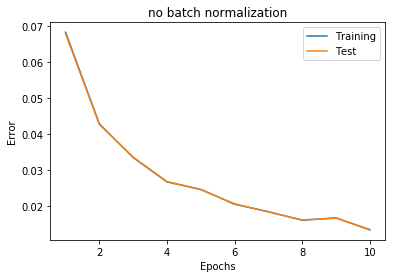

In [19]:

#%%
plt.figure()
plt.plot(range(1,11),1.0-np.array(acc_train),label='Training')
plt.plot(range(1,11),1.0-np.array(acc_test),label='Test')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('no batch normalization')
plt.legend()
plt.savefig('problem1c-no-bn.pdf')
plt.show()

 ### Define the cnn model with batch normalization

In [20]:

'''
train cnn classifier with batch normalization
'''
class CNN_BN_Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(CNN_BN_Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(16),
#             nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32)  ,          
#             nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
#             nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
#             nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(128, 10)
#         self.bn = nn.BatchNorm1d(10)

    def forward(self, x):
#         return self.bn(self.clf(self.conv(x).squeeze()))
        return self.clf(self.conv(x).squeeze())

### train cnn classifier with batch normalization

In [21]:
#%%
### train cnn classifier 
cuda_available = torch.cuda.is_available()
model_cnn2 = CNN_BN_Classifier()
if cuda_available:
    model_cnn2 = model_cnn2.cuda()
optimizer = torch.optim.Adam(model_cnn2.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

acc_train = list()
acc_test = list()

for epoch in range(10):
    losses = []
    # Train
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = model_cnn2(inputs)
        loss = criterion(outputs, targets)
        # print(loss)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])

    print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))
    
    # Evaluate
    model_cnn2.eval()
    total = 0
    correct = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets = Variable(inputs, volatile=True), Variable(targets, volatile=True)
        outputs = model_cnn2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    acc_train.append(correct/total)
    print('Epoch : %d Train Acc : %.3f' % (epoch, 100.*correct/total))

    for batch_idx, (inputs, targets) in enumerate(testloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets = Variable(inputs, volatile=True), Variable(targets, volatile=True)
        outputs = model_cnn2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    acc_test.append(correct/total)

    print('Epoch : %d Test Acc : %.3f' % (epoch, 100.*correct/total))
    print('--------------------------------------------------------------')
    model_cnn2.train()

    #%%


Epoch : 0 Loss : 0.483 
Epoch : 0 Train Acc : 97.788
Epoch : 0 Test Acc : 97.817
--------------------------------------------------------------
Epoch : 1 Loss : 0.087 
Epoch : 1 Train Acc : 98.695
Epoch : 1 Test Acc : 98.689
--------------------------------------------------------------
Epoch : 2 Loss : 0.052 
Epoch : 2 Train Acc : 99.088
Epoch : 2 Test Acc : 99.047
--------------------------------------------------------------
Epoch : 3 Loss : 0.037 
Epoch : 3 Train Acc : 99.363
Epoch : 3 Test Acc : 99.306
--------------------------------------------------------------
Epoch : 4 Loss : 0.028 
Epoch : 4 Train Acc : 99.517
Epoch : 4 Test Acc : 99.456
--------------------------------------------------------------
Epoch : 5 Loss : 0.022 
Epoch : 5 Train Acc : 99.615
Epoch : 5 Test Acc : 99.511
--------------------------------------------------------------
Epoch : 6 Loss : 0.018 
Epoch : 6 Train Acc : 99.755
Epoch : 6 Test Acc : 99.663
-------------------------------------------------------

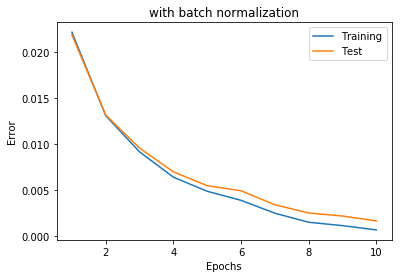

In [22]:

#%%
plt.figure()
plt.plot(range(1,11),1.0-np.array(acc_train),label='Training')
plt.plot(range(1,11),1.0-np.array(acc_test),label='Test')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('with batch normalization')
plt.legend()
plt.savefig('problem1c-with-bn.pdf')
plt.show()